In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import logging
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from darts import TimeSeries
from darts.models import *
from darts.metrics import *
from darts.dataprocessing.transformers import Scaler

mpl.rcParams['figure.dpi'] = 300
logging.disable(logging.CRITICAL)

Importing plotly failed. Interactive plots will not work.


In [18]:
df = pd.read_csv('data/monthly_in_situ_co2_mlo.csv',
                 comment = '"', header = [0,1,2], na_values = '-99.99')

cols = [' '.join(col).replace(' ', '') for col in df.columns.values]
df.set_axis(cols, axis = 1, inplace = True)

# Converting Excel date format to datetime
# and setting as dataframe index
df['datetime'] = pd.to_datetime(df['DateExcel'], origin = '1899-12-30', unit = 'D')
df.set_index('datetime', inplace = True)

df = df[['CO2filled[ppm]']]
df.rename(columns = {'CO2filled[ppm]': 'CO2'}, inplace = True)
df.dropna(inplace = True)
df = df.resample('M').sum()

In [17]:
df

,CO2
datetime,
1958-03-31,315.70
1958-04-30,317.45
1958-05-31,317.51
1958-06-30,317.25
1958-07-31,315.86
...,...
2021-08-31,414.34
2021-09-30,412.90
2021-10-31,413.55


## Time Series Analysis
In this section, we are going to analyze the dataset so we can understand its basic statistical properties, something that can be accomplished by creating various types of visualizations.

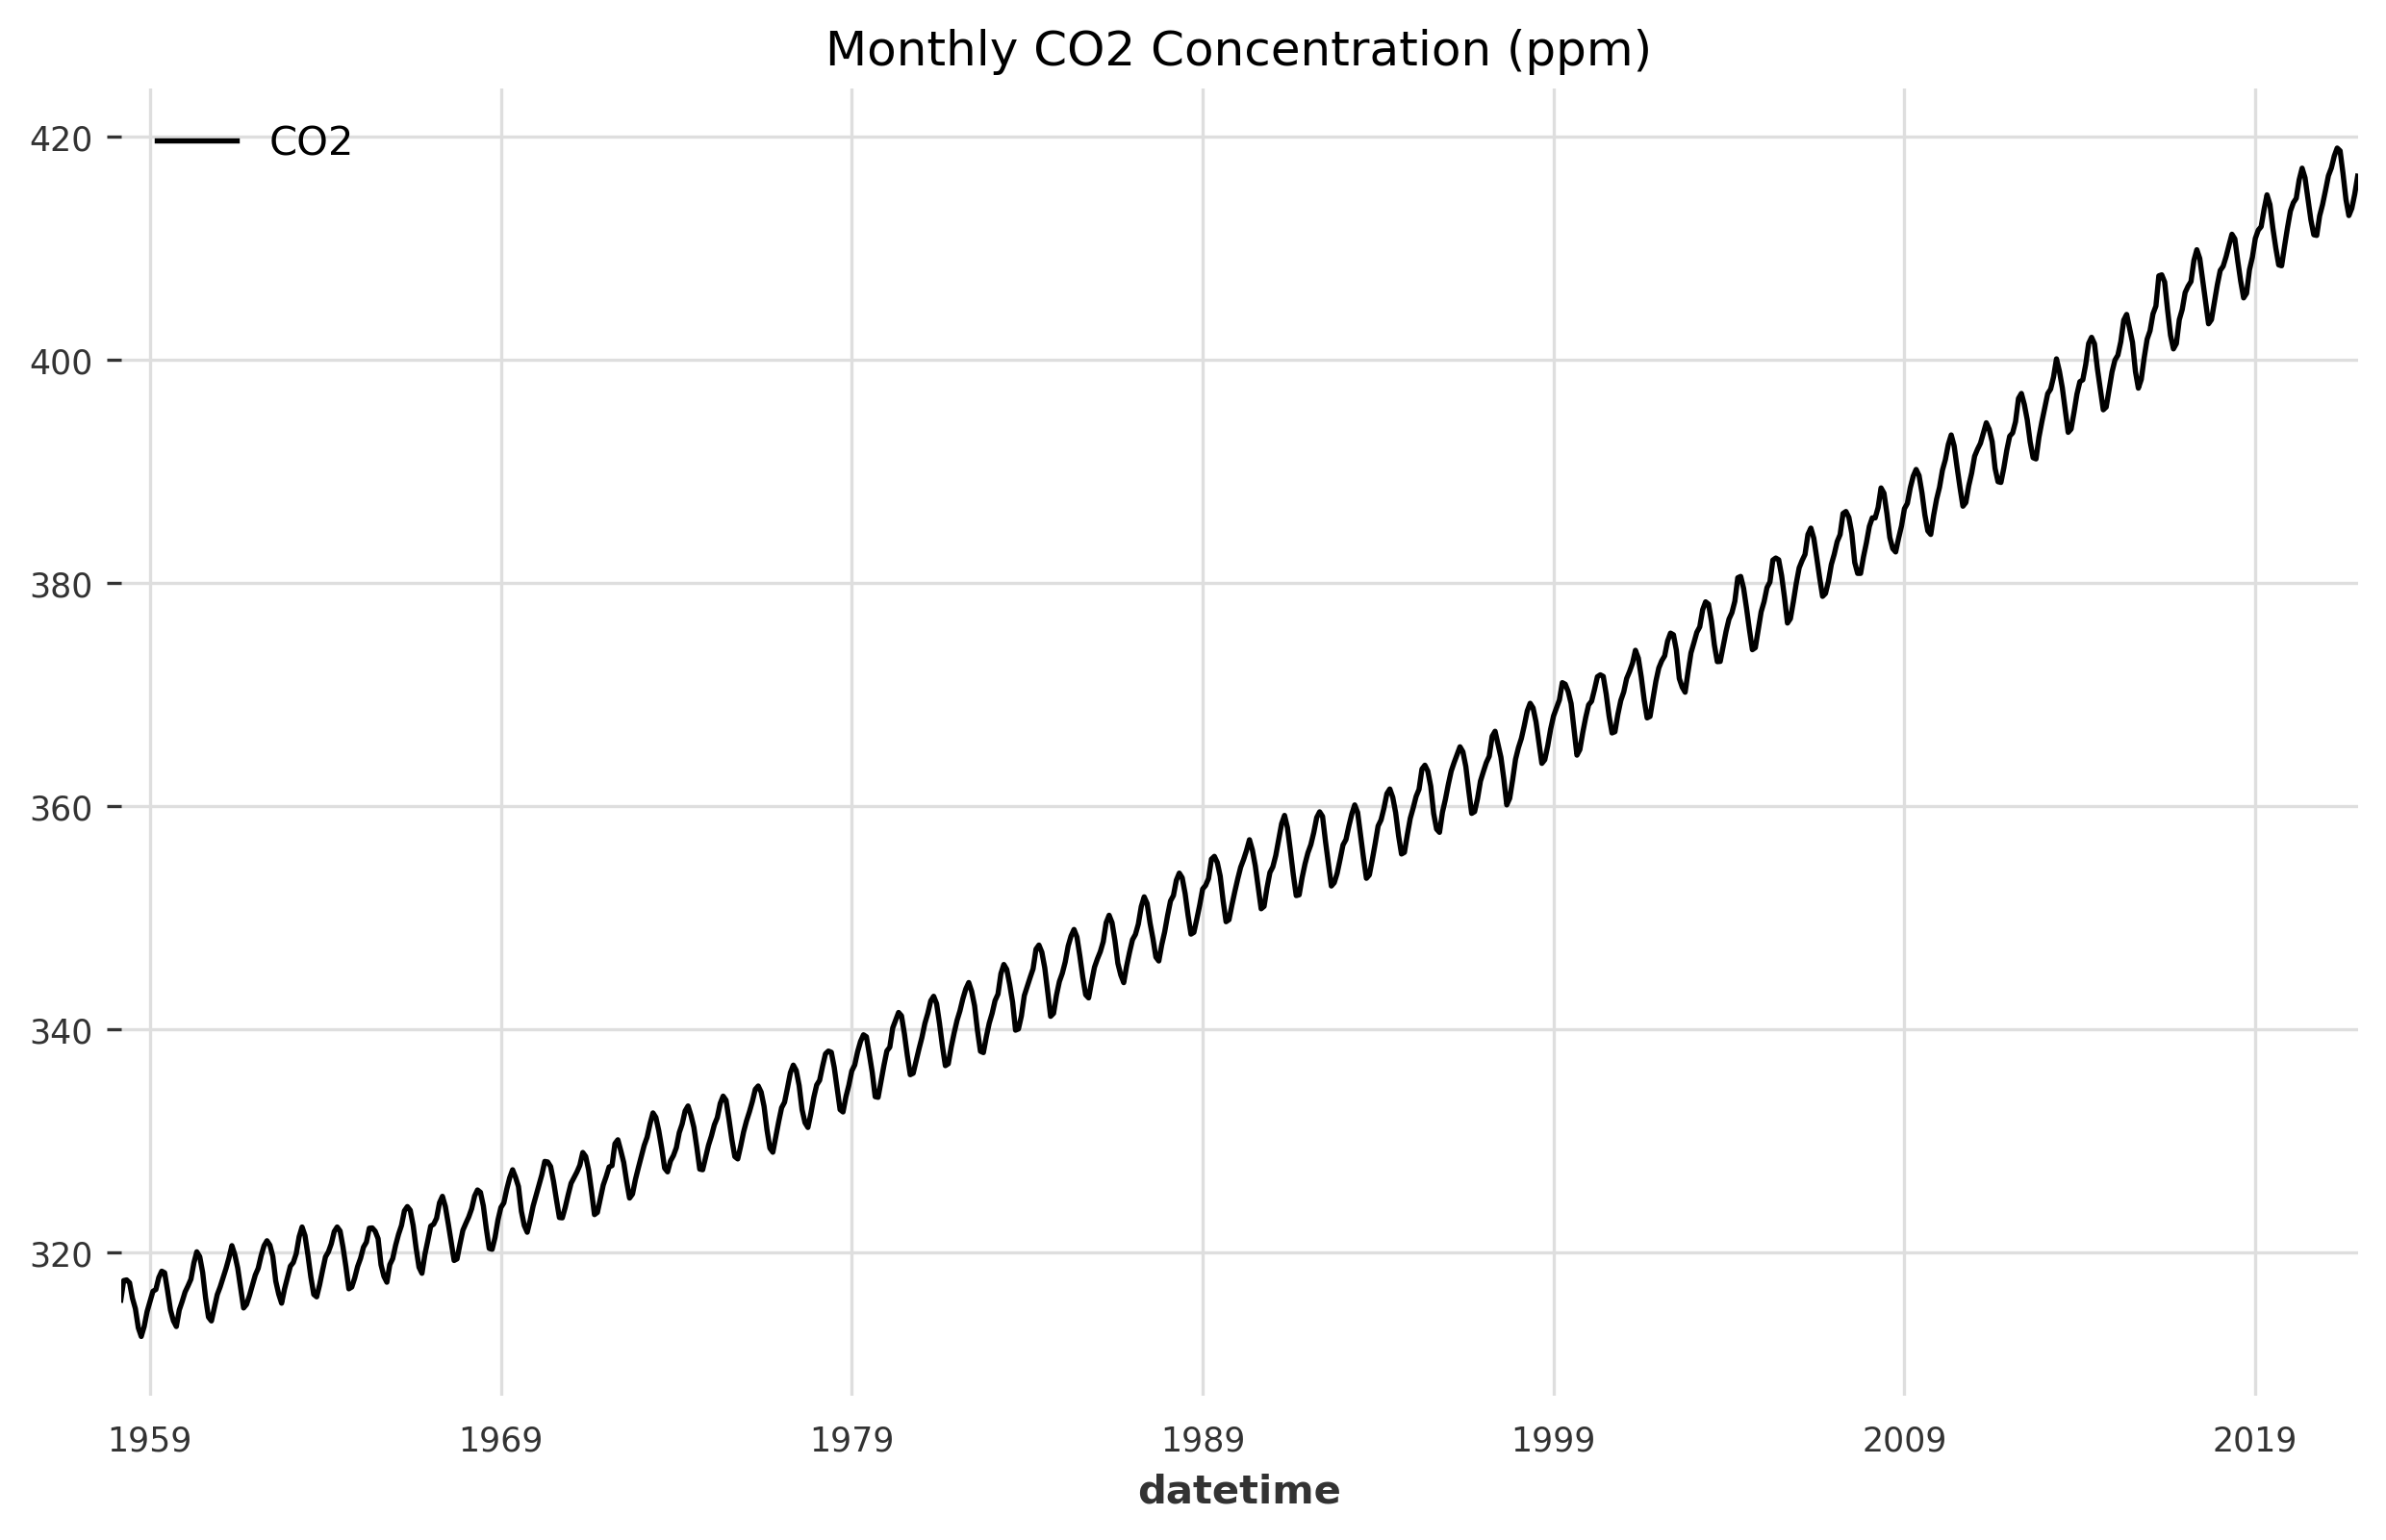

In [10]:
df.plot(figsize=(10,6))
plt.title('Monthly CO2 Concentration (ppm)')

plt.show()

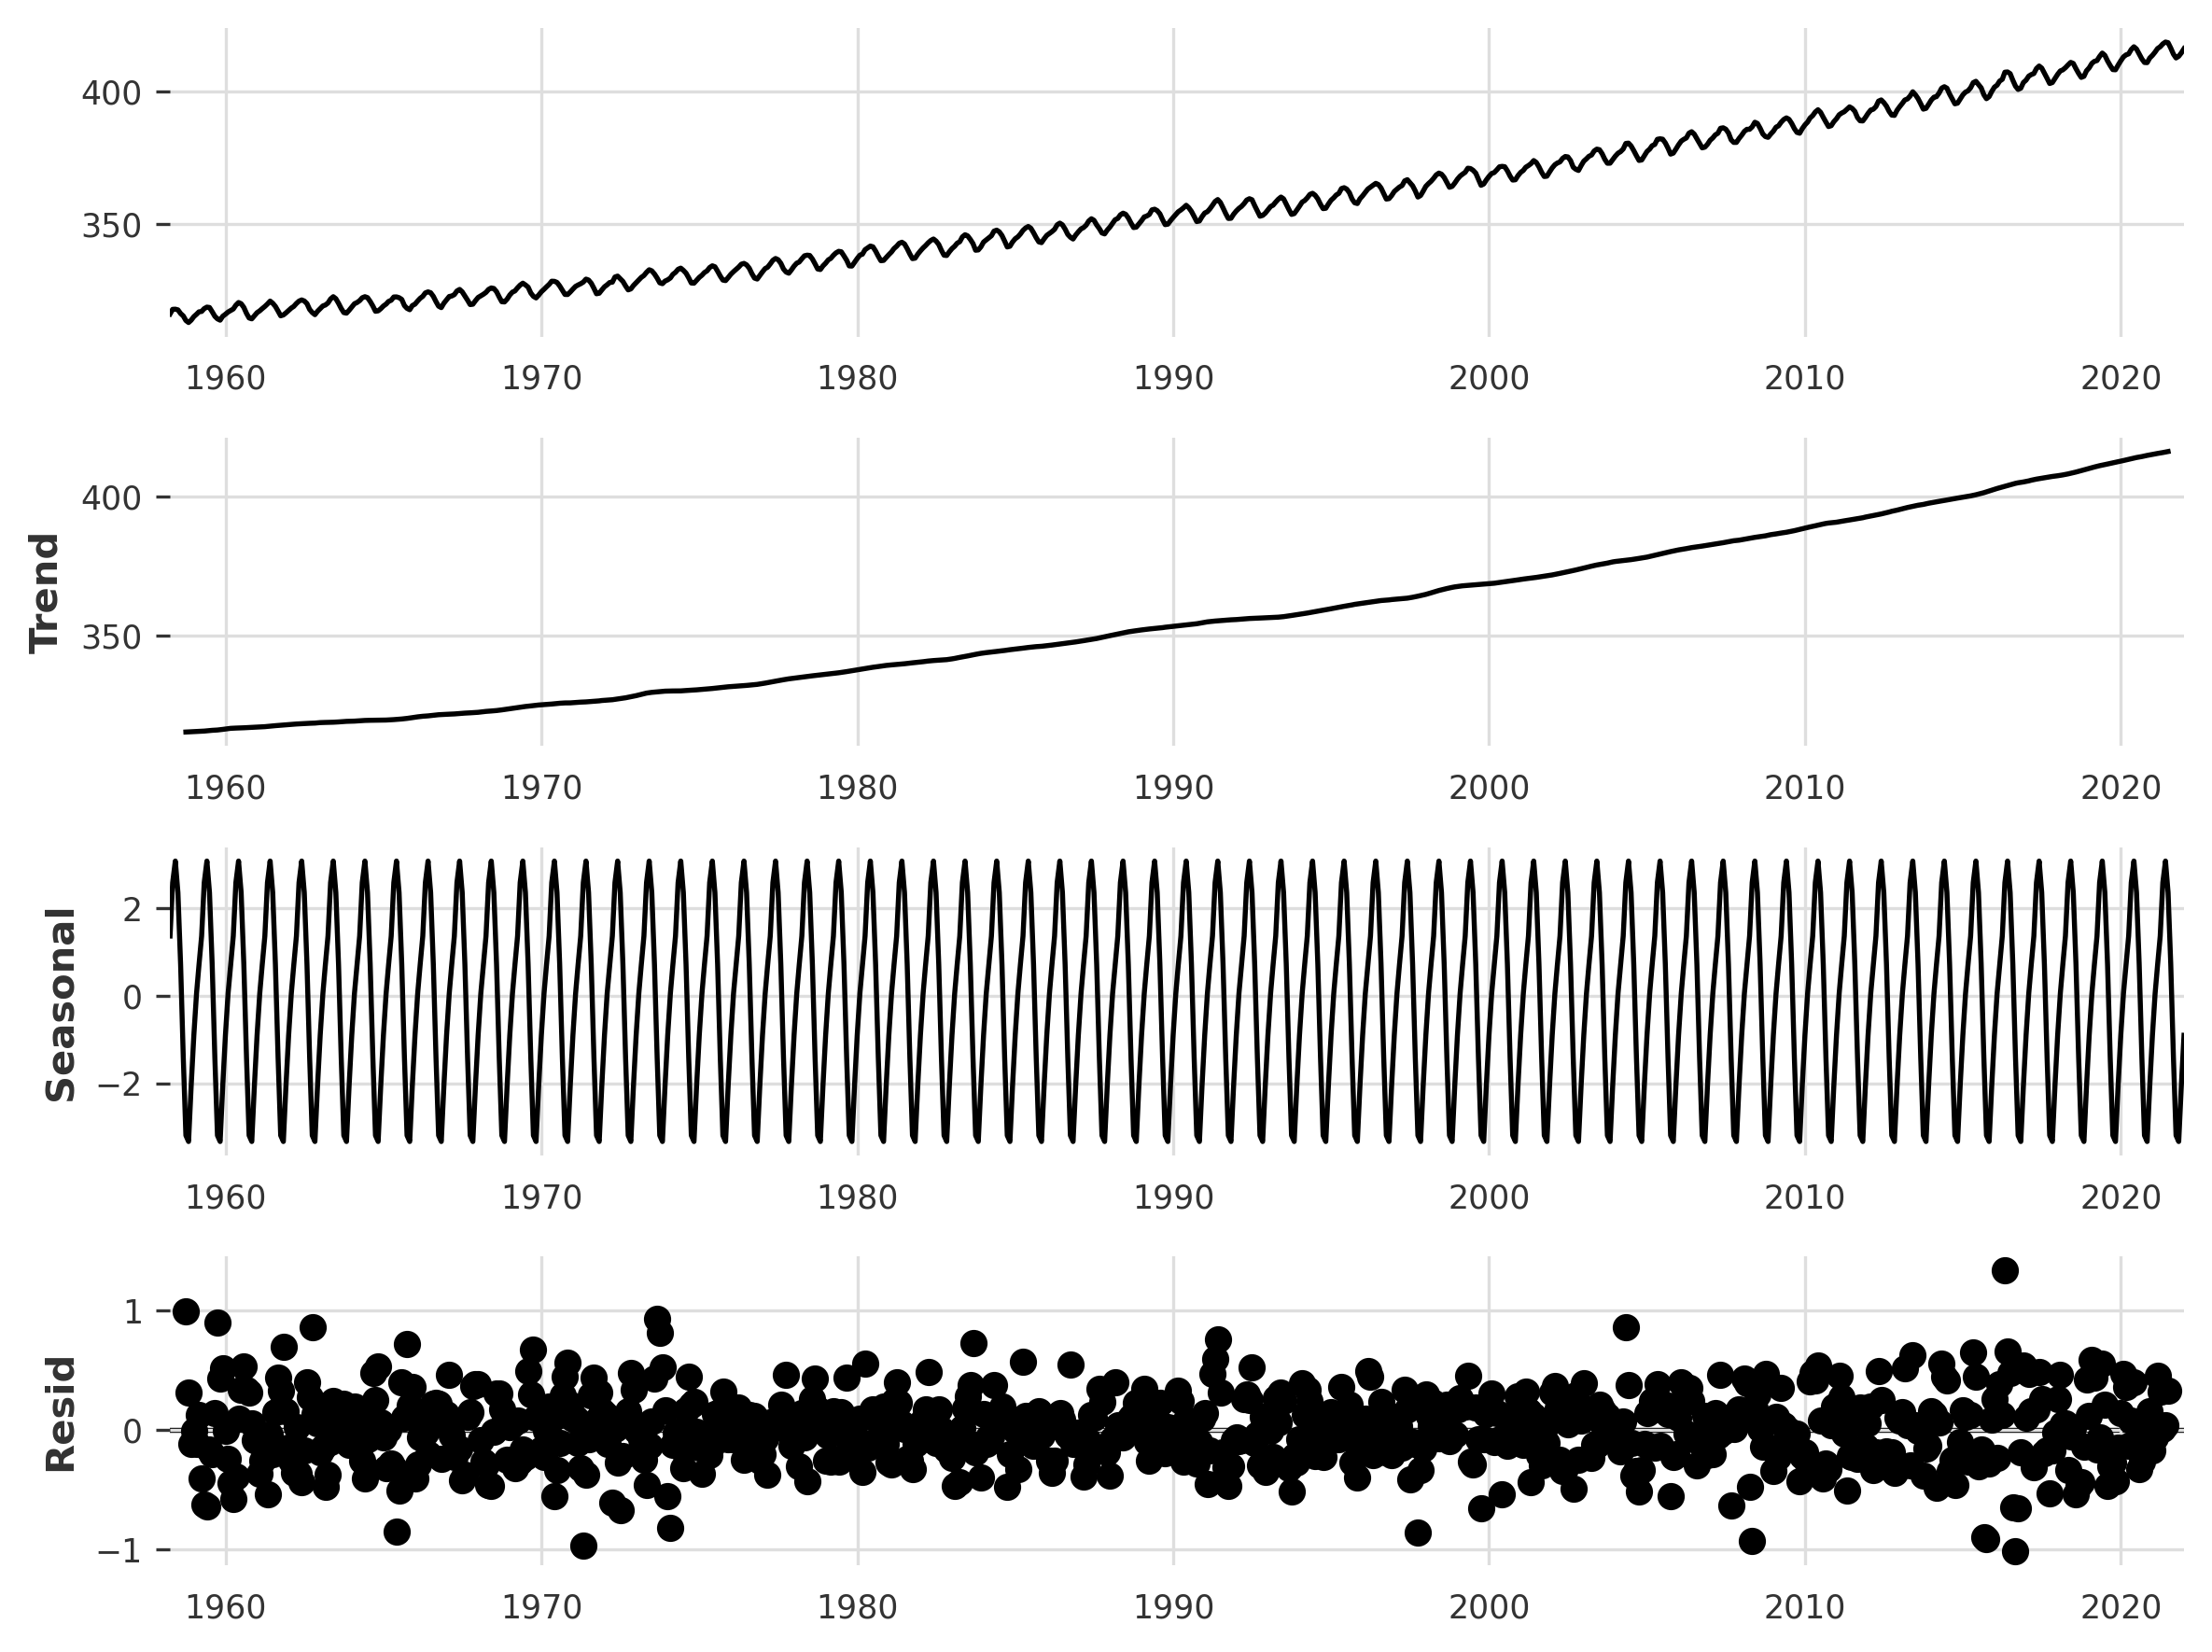

In [5]:
mpl.rcParams['figure.figsize'] = (8, 6)

result = seasonal_decompose(df)
result.plot()

plt.show()

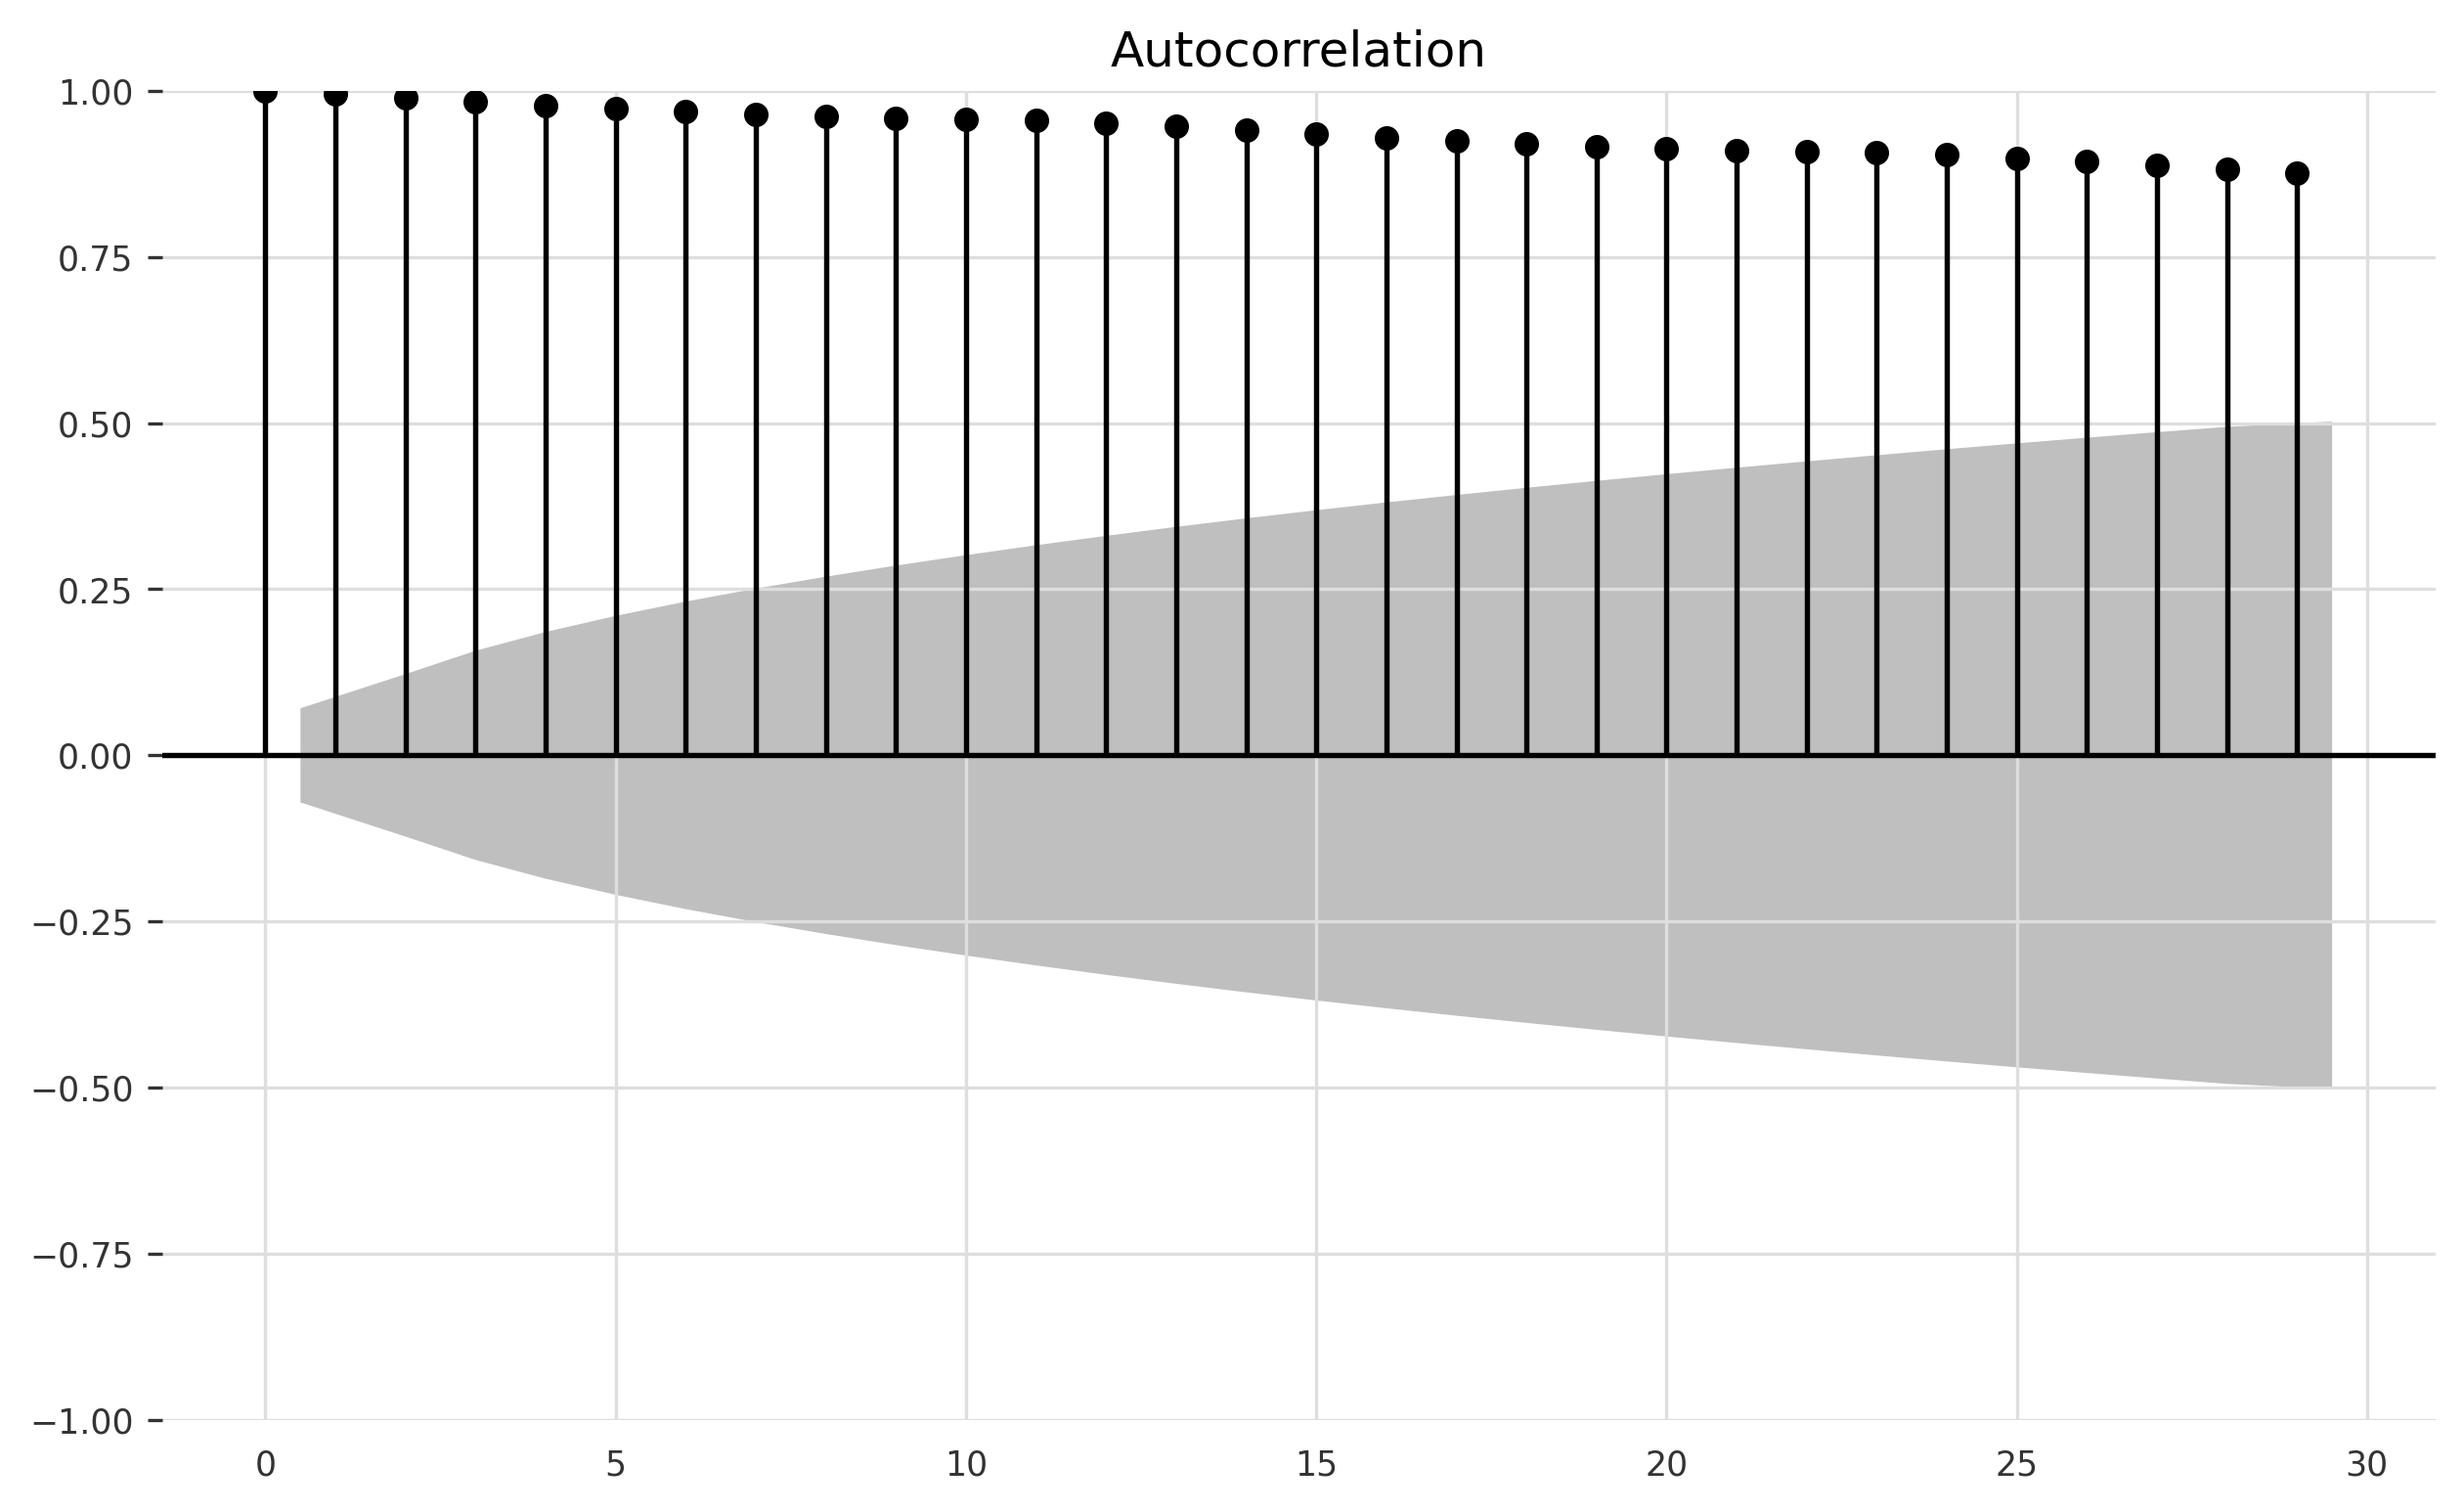

In [6]:
fig, ax = plt.subplots(figsize = (10,6))

plot_acf(df, ax = ax)

plt.show()

In [7]:
#Loading the pandas dataframe to a TimeSeries object
#As required by the Darts library
series = TimeSeries.from_dataframe(df)

start = pd.Timestamp('123118')
df_metrics = pd.DataFrame()

### Creating Utility Functions

In [8]:
def backtest(series, model, start):
    
    historical_fcast = model.historical_forecasts(series, start=start, forecast_horizon=12,                                   
                                                  verbose = True)
    return historical_fcast

def plot_backtest(series, forecast, model_name):
    idx = -144
    series[idx:].plot(label='Actual Values')
    forecast[idx:].plot(label= 'Forecast')
    plt.title(model_name)
    plt.show()
    
def print_metrics(series, forecast, model_name):
    mae_ = mae(series, forecast)
    rmse_ = rmse(series, forecast)
    mape_ = mape(series, forecast)
    smape_ = smape(series, forecast)
    r2_score_ = r2_score(series, forecast)
    
    dict_ = {'MAE': mae_, 'RMSE': rmse_,
             'MAPE': mape_, 'SMAPE': smape_, 
             'R2': r2_score_}
             
    
    df = pd.DataFrame(dict_, index = [model_name])
    return(df.round(decimals = 2))       
    

### Creating a Naive Forecasting Model
We begin by setting a baseline accuracy with a naive forecasting model. This will help us evaluate the performance of more complex models, that theoretically should have higher accuracy than the baseline.

  0%|          | 0/26 [00:00<?, ?it/s]

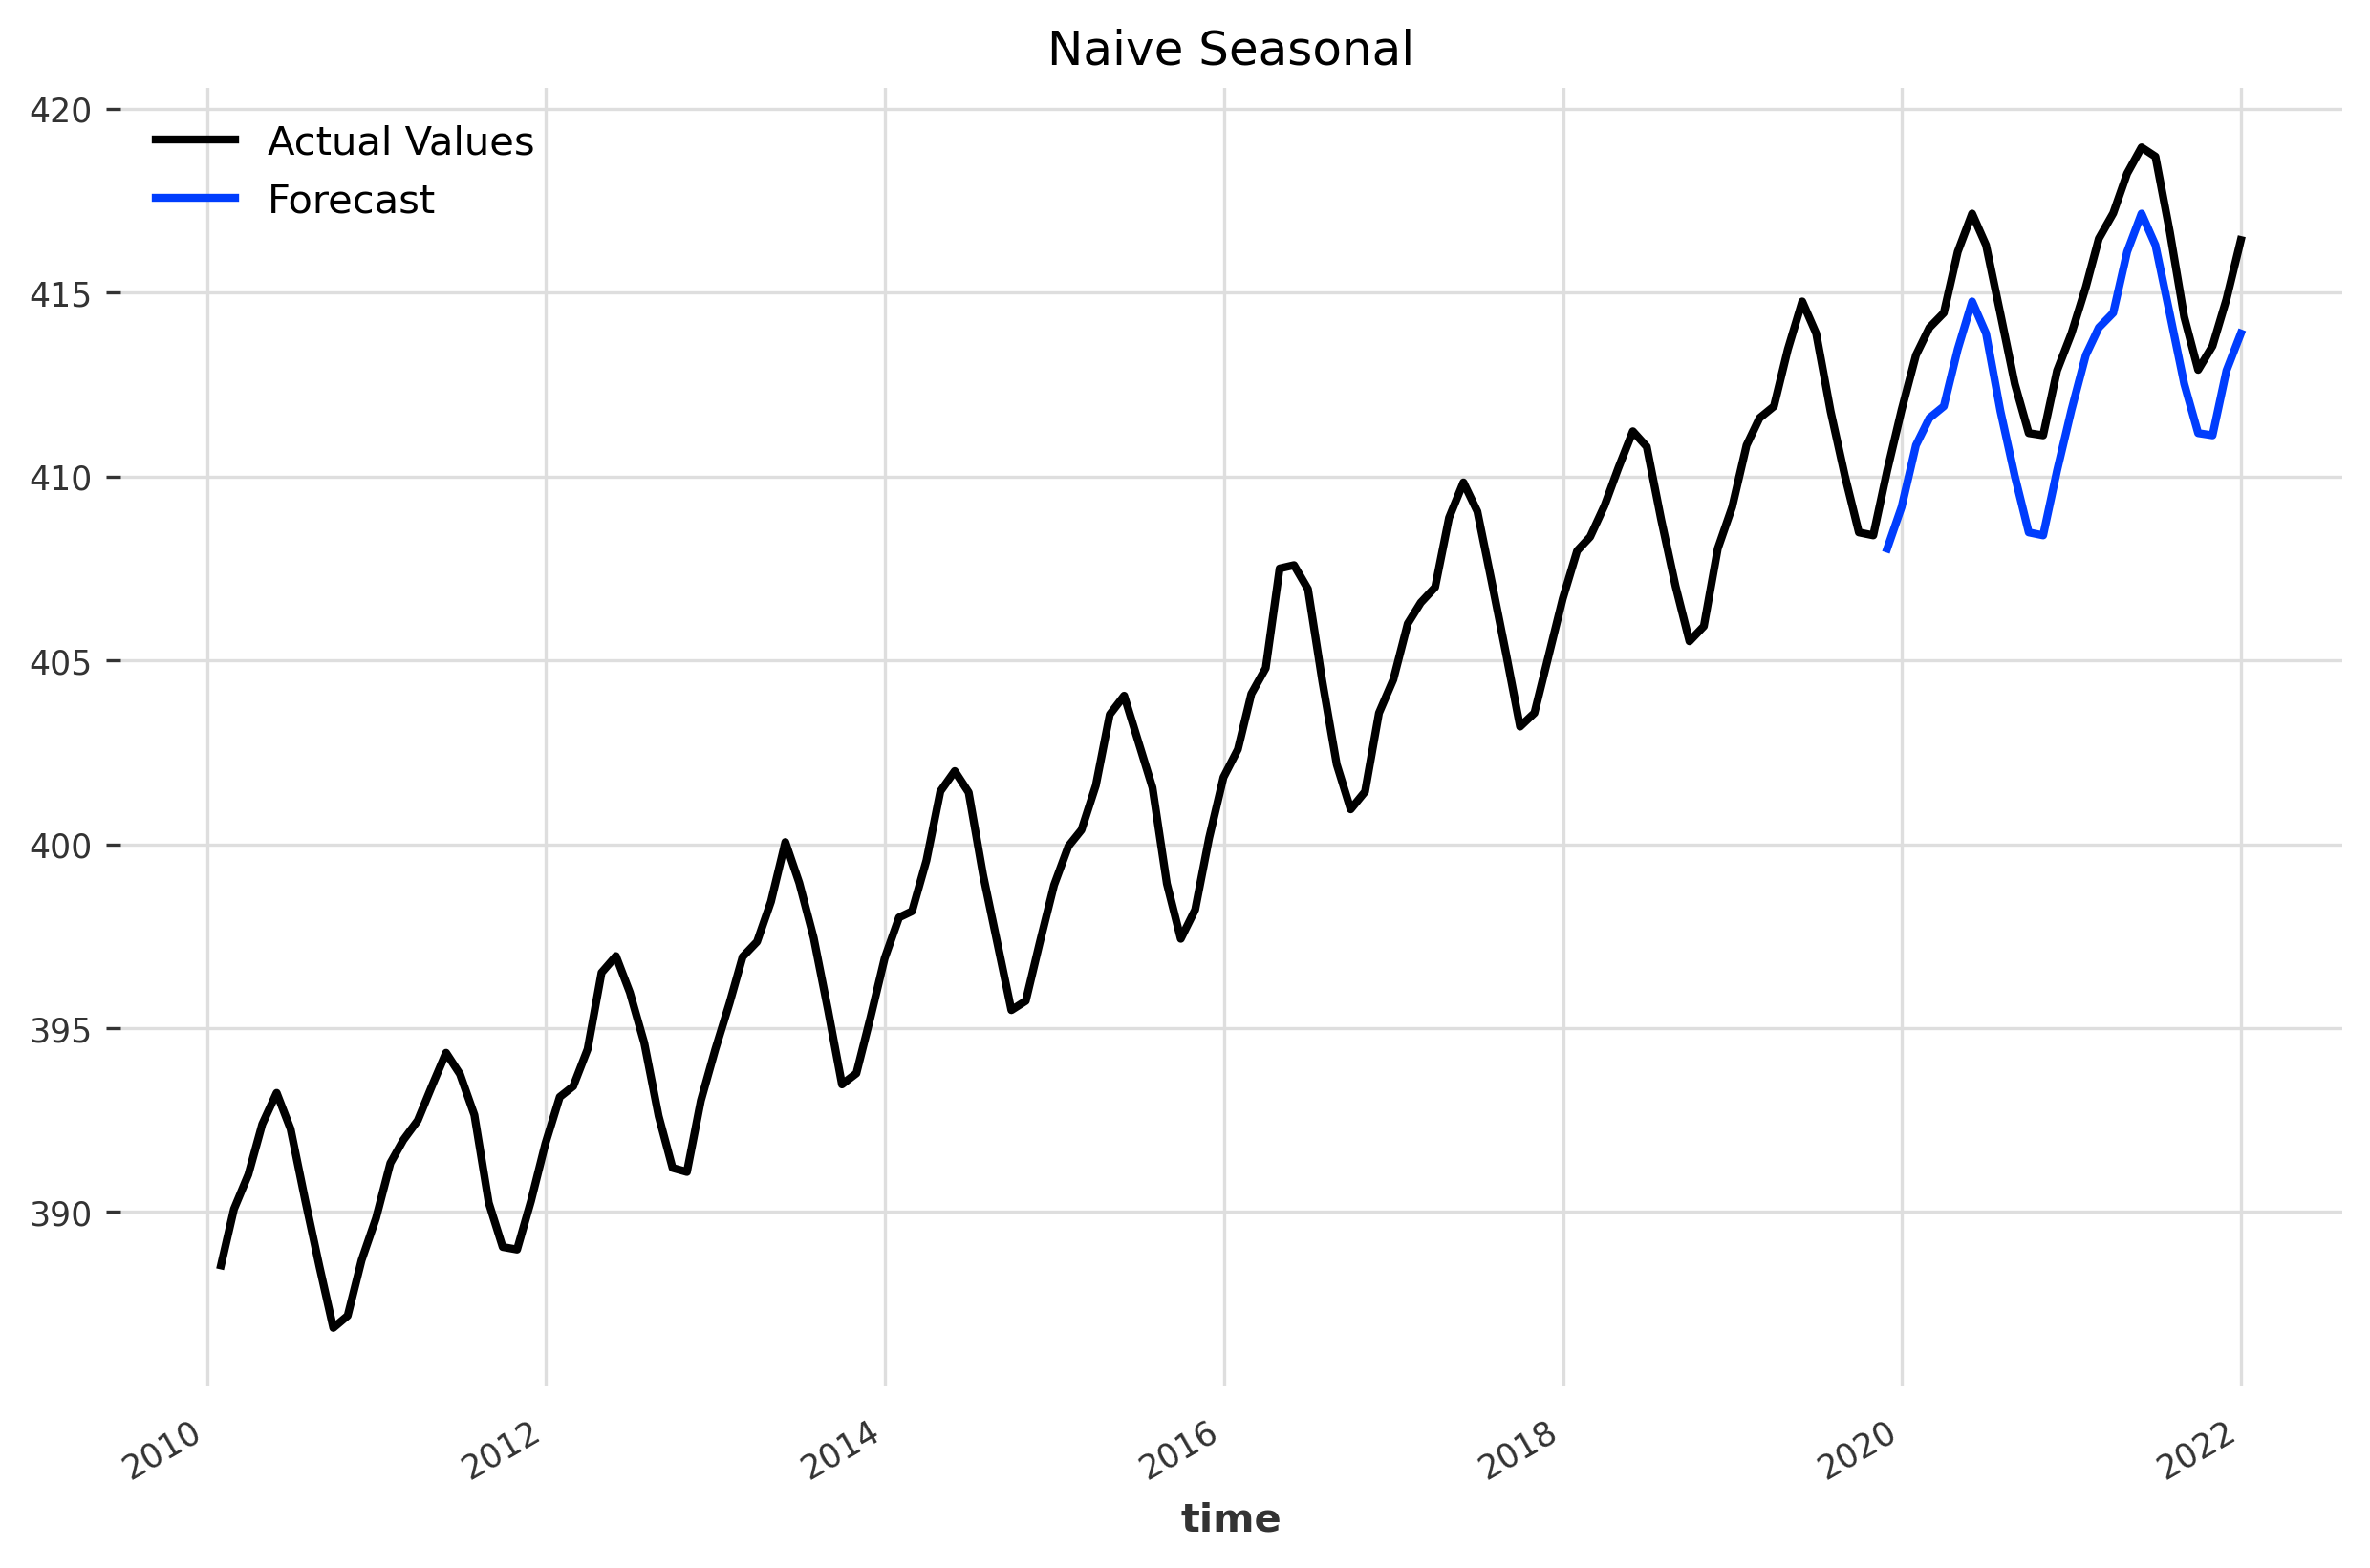

,MAE,RMSE,MAPE,SMAPE,R2
Naive Seasonal,2.35,2.37,0.57,0.57,-0.02


In [9]:
model = NaiveSeasonal(K = 12)
model_name = 'Naive Seasonal'

plt.figure(figsize = (10, 6))

forecast = backtest(series, model, start)
plot_backtest(series, forecast, model_name)
df_naive = print_metrics(series, forecast, model_name)
df_metrics = df_metrics.append(df_naive)

plt.show()
df_naive

### Creating an Exponential Smoothing Forecasting Model

  0%|          | 0/26 [00:00<?, ?it/s]

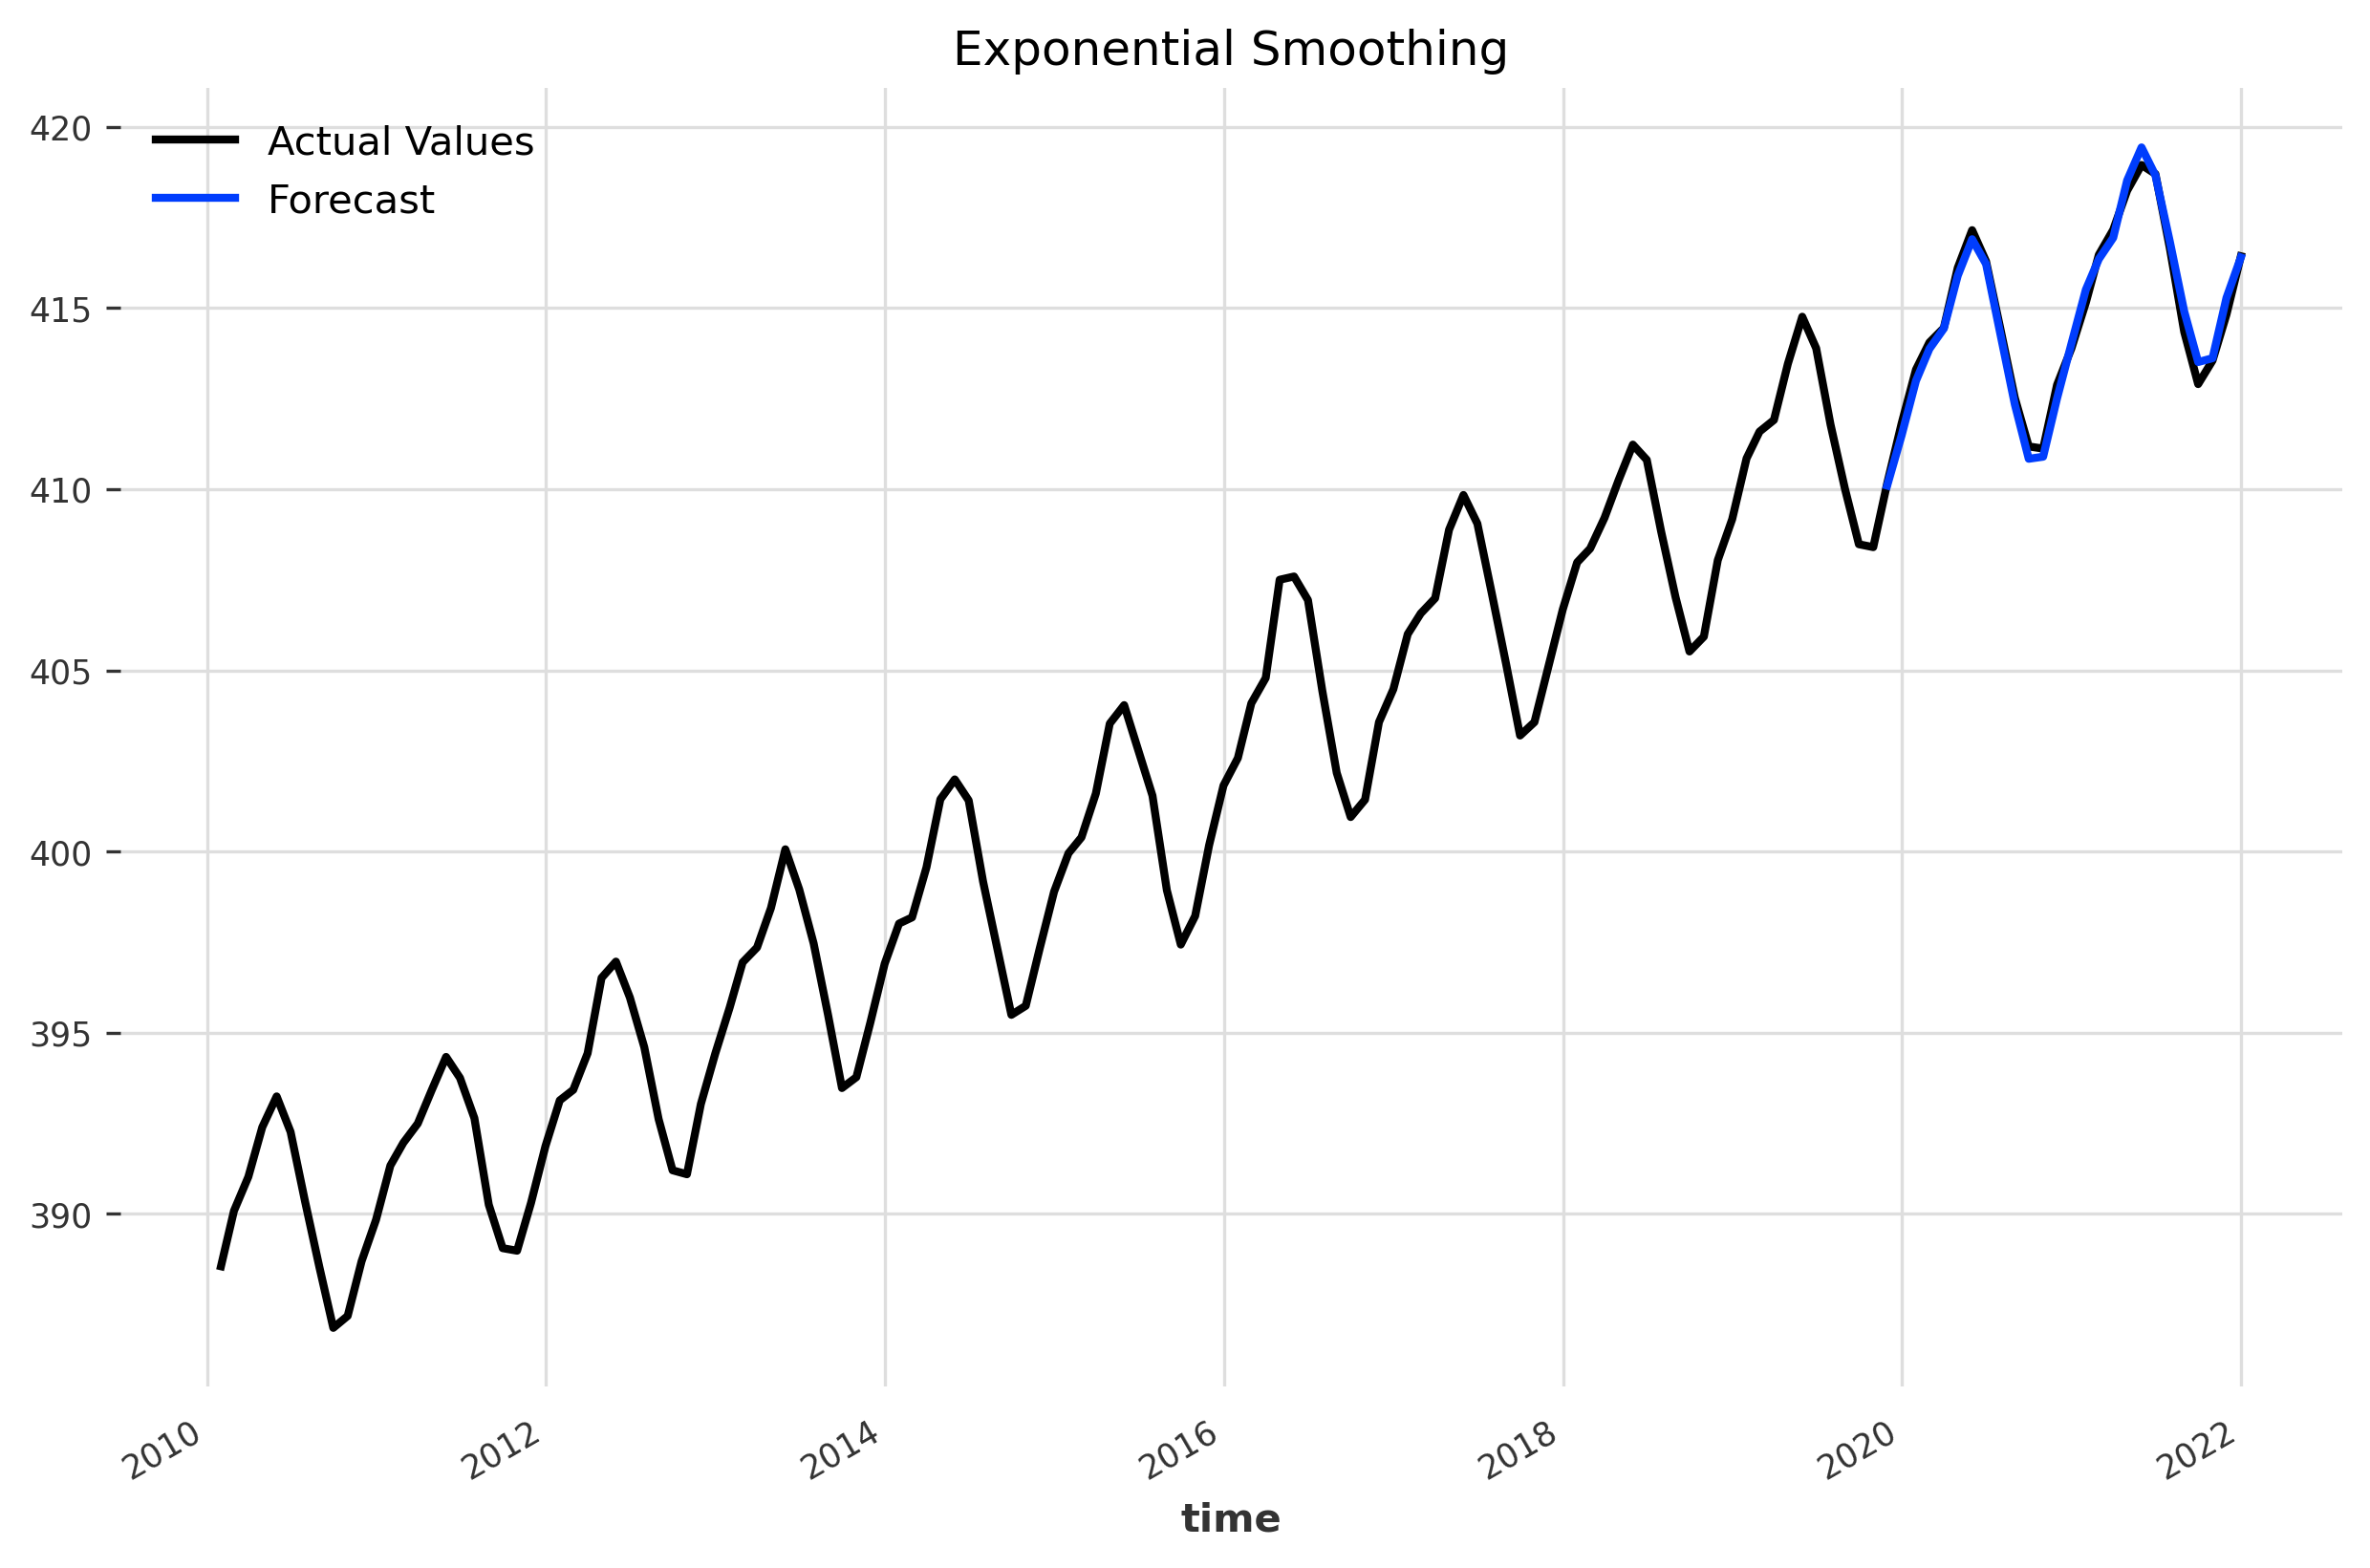

,MAE,RMSE,MAPE,SMAPE,R2
Exponential Smoothing,0.24,0.29,0.06,0.06,0.98


In [10]:
model = ExponentialSmoothing()
model_name = 'Exponential Smoothing'

plt.figure(figsize = (10, 6))

forecast = backtest(series, model, start)
plot_backtest(series, forecast, model_name)
df_exp = print_metrics(series, forecast, model_name)
df_metrics = df_metrics.append(df_exp)

plt.show()
df_exp

### Creating a Linear Regression Forecasting Model

  0%|          | 0/26 [00:00<?, ?it/s]

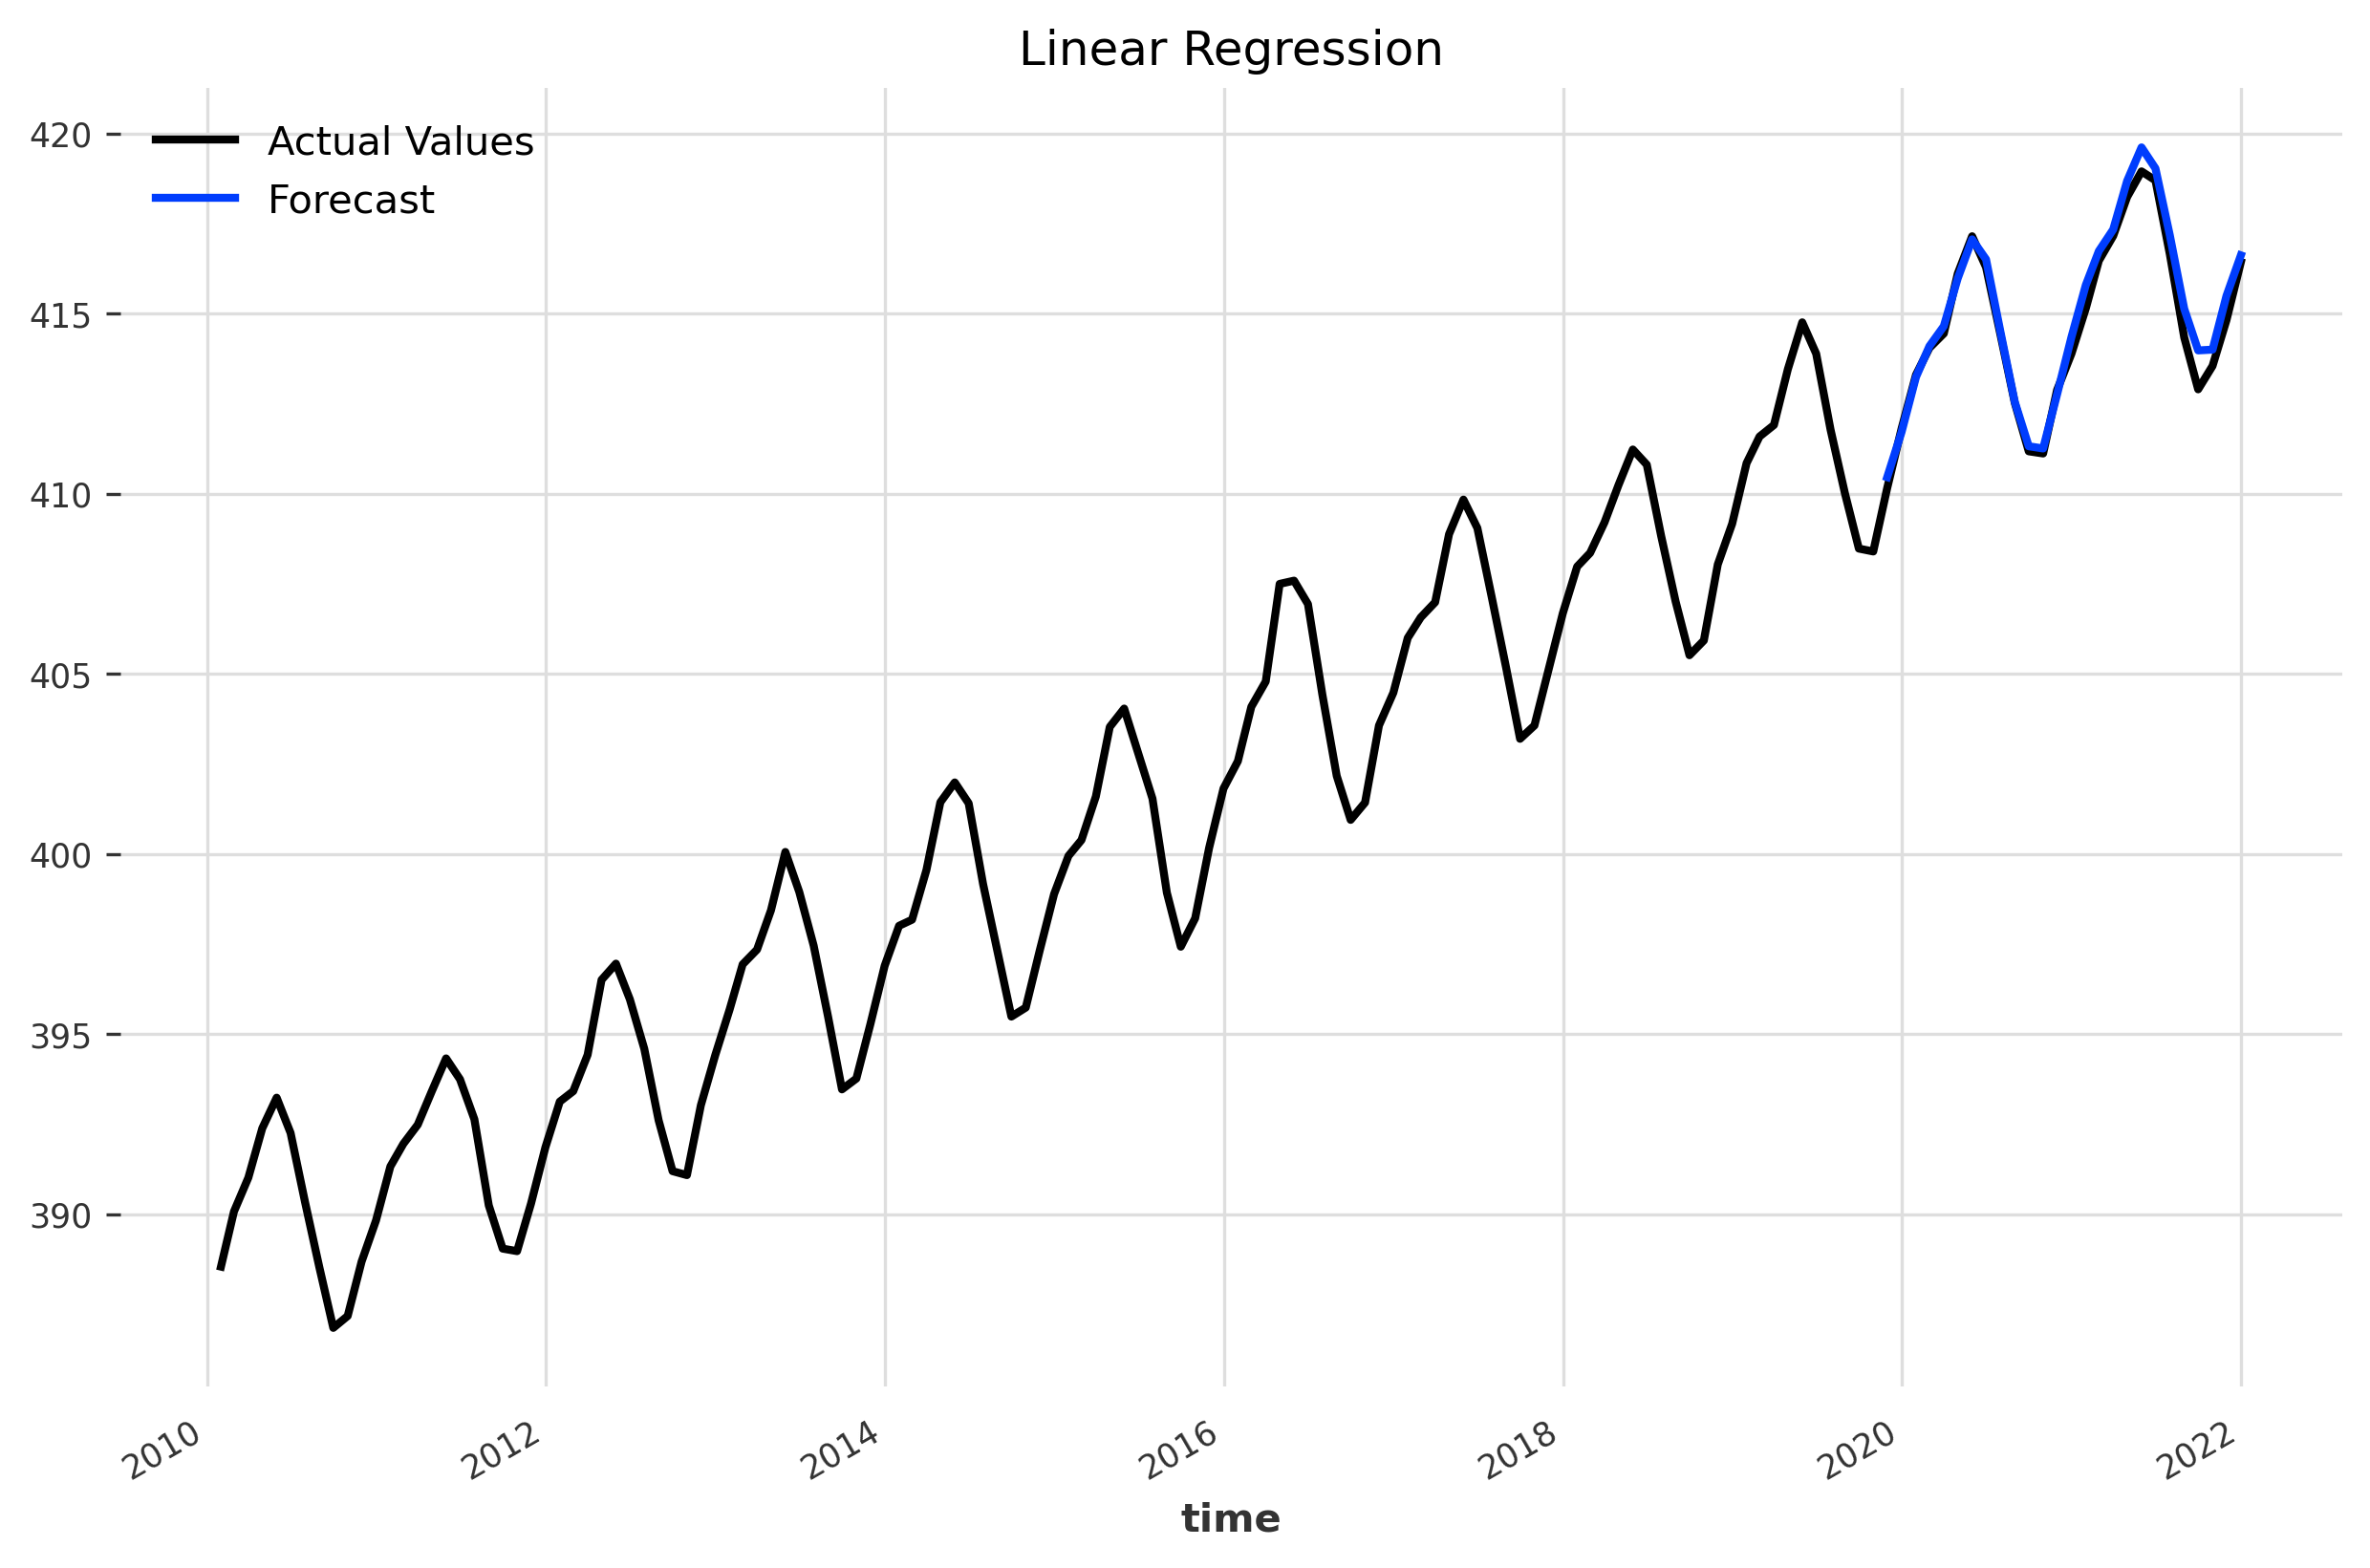

,MAE,RMSE,MAPE,SMAPE,R2
Linear Regression,0.32,0.42,0.08,0.08,0.97


In [11]:
model = LinearRegressionModel(lags = 12)
model_name = 'Linear Regression'

plt.figure(figsize = (10, 6))

forecast = backtest(series, model, start)
plot_backtest(series, forecast, model_name)
df_lr = print_metrics(series, forecast, model_name)
df_metrics = df_metrics.append(df_lr)

plt.show()
df_lr